## Data understanding

In [111]:
import pandas as pd

dataset = pd.read_csv("prima-indians.csv", names=list("abcdefgho"))
dataset.head()

a    b   c   d    e     f      g   h  o
0  6  148  72  35    0  33.6  0.627  50  1
1  1   85  66  29    0  26.6  0.351  31  0
2  8  183  64   0    0  23.3  0.672  32  1
3  1   89  66  23   94  28.1  0.167  21  0
4  0  137  40  35  168  43.1  2.288  33  1

In [112]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
a    768 non-null int64
b    768 non-null int64
c    768 non-null int64
d    768 non-null int64
e    768 non-null int64
f    768 non-null float64
g    768 non-null float64
h    768 non-null int64
o    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [113]:
dataset.describe()

a           b           c           d           e           f  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                g           h           o  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%      0.372500   29.000000    0.000000  
75%      0.626250   41.000000    1.000000  
max      2.420000   81.000000    1.000000

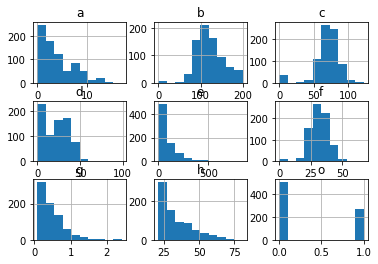

In [114]:
from matplotlib import pyplot as plt

fig = dataset.hist()

## Test-Train Split

In [42]:
from sklearn.model_selection import train_test_split

y = dataset["o"]
X = dataset.drop("o", axis=1)
trainX, testX, trainY, testY = train_test_split(X, y)
trainX.shape, testX.shape, trainY.shape, testY.shape

((576, 8), (192, 8), (576,), (192,))

## Benchmarking Scikit-learn's native implementation

In [105]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(trainX, trainY)

GaussianNB(priors=None, var_smoothing=1e-09)

## Implementing Gaussian Naive Bayes 

In [184]:
import numpy as np
from functools import reduce

class GNB(object):
    
    @staticmethod
    def _unique_classes(y):
        return np.unique(y)
    
    def _prob_of_hypothesis(self, y):
        norm = float(len(y))
        p_h = {h: sum(y==h)/norm for h in self.unique_classes}
        
        return p_h
        
    def _joint_pdf_f_h(self, X, y):
        
        pdf = dict()
        for h in self.unique_classes:
            thisX = X[y == h]
            mean_std = zip(*[thisX.mean(axis=0), thisX.std(axis=0)])
            pdf[h] = {idx: [mean, std] for idx, (mean, std) in enumerate(mean_std)}    
        
        return pdf
        
    def fit(self, X, y):
        '''
        Assuming X & y are valid training samples with equal number of features
        and each feature in X assume a guassian distribution
        '''
        self.unique_classes = self._unique_classes(y=y)
        self.p_h = self._prob_of_hypothesis(y=y)
        self.joint_pdf = self._joint_pdf_f_h(X=X, y=y)
    
    @staticmethod
    def _guassian_pdf(f, mean, std):
        pi = 3.1416
        return (1./(np.sqrt(2*pi) * std)) * (np.exp(-((f - mean)**2)/(2*std**2)))
        
    def _posterior_prob(self, x):
        proba = []
        for h in self.unique_classes:
            proba.append(reduce(
                lambda x, y: x * y, 
                [self._guassian_pdf(*[x_idx] + self.joint_pdf[h][idx])
                 for idx, x_idx in enumerate(x)]))
        
        return proba
    
    def predict(self, X):
        '''
        Assuming individual features in X exist and follow the same distribution as their corresponding training data 
        '''
        predictions = []
        for sample in X:
            predictions.append(np.argmax(self._posterior_prob(x=sample)))
            
        return np.array(predictions)
        
        
    def score(self, X, y):
        return sum(y == self.predict(X))/ len(y)
                

#### Benchmarking

In [185]:
gnb = GNB()
gnb.fit(X=trainX.values, y=trainY.values)
my_pred = gnb.predict(X=testX.values)
sk_pred = clf.predict(X=testX.values)

print("Scikit-learn implementation accuracy: {0:.2f}\n"
     "My GNB implementation accuracy: {1:.2f}\n"
     "What portion of two classifiers' prediction matches: {2:.2f}\n".format(
         clf.score(X=testX.values, y=testY.values),
         gnb.score(X=testX.values, y=testY.values),
         sum(my_pred == sk_pred)/len(sk_pred)))

Scikit-learn implementation accuracy: 0.69
My GNB implementation accuracy: 0.67
What portion of two classifiers' prediction matches: 0.93



#### Modelled stats

In [84]:
gnb.p_h

{0: 0.65625, 1: 0.34375}

In [87]:
gnb.joint_pdf

{0: {0: [3.3492063492063493, 3.0166665622664057],
  1: [108.78042328042328, 24.916515375252054],
  2: [68.1058201058201, 18.3347594824641],
  3: [19.57936507936508, 14.727158715437264],
  4: [66.38095238095238, 94.50692344472515],
  5: [30.27830687830688, 8.047307564527458],
  6: [0.4344603174603173, 0.3000350063560129],
  7: [31.203703703703702, 10.904505502352354]},
 1: {0: [5.025252525252525, 3.7851875961768666],
  1: [143.62121212121212, 32.43366119217413],
  2: [70.5959595959596, 21.977683443295852],
  3: [21.52020202020202, 17.52824836851301],
  4: [102.43939393939394, 141.37440035020555],
  5: [35.28888888888888, 6.854083629617875],
  6: [0.5594898989898994, 0.37145115017815833],
  7: [37.26262626262626, 10.726240700608535]}}

## TO-DO

* Extent the GNB's capabilities to assume other input distributions too:
        * Bernoulli (Binomial/ Multinomial)
        * Exponential distribution
* Observe modelling performance by mixing multiple distributions (something like: (exp + gaussian) etc.) to model input feature distributions
        
